## RNN model 

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import tensorflow as tf
import keras_tuner as kt
import pickle
from tensorflow.keras.models import load_model
import import_ipynb
from feature_engineering import scaler_y

In [33]:
# Data Import 

# Load X_train
with open("data/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

# Load y_train
with open("data/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

# Load X_val
with open("data/X_val.pkl", "rb") as f:
    X_val = pickle.load(f)

# Load y_val
with open("data/y_val.pkl", "rb") as f:
    y_val = pickle.load(f)

# Load X_test
with open("data/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

# Load y_test
with open("data/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

# Load df_final_viz
with open("data/df_final_viz.pkl", "rb") as f:
    df_final_viz = pickle.load(f)


In [27]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

In [40]:
rnn_model = Sequential([
    SimpleRNN(48, input_shape=(None, X_train.shape[2])),
    Dropout(0.1),
    Dense(56),
    Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 0.9**epoch)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_1.h5", monitor= "val_loss", save_best_only=True)
optimizer = tf.keras.optimizers.Adam(amsgrad=True)

rnn_model.compile(optimizer=optimizer, loss='mse', metrics = tf.keras.metrics.RootMeanSquaredError())
history = rnn_model.fit(X_train, y_train, epochs=50, validation_data = (X_val, y_val), batch_size=32, verbose=1, callbacks = [early_stopping, model_checkpoint, lr_schedule])


Epoch 1/50
845/845 [==============================] - 4s 4ms/step - loss: 0.0081 - root_mean_squared_error: 0.0899 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540 - lr: 0.0010
Epoch 2/50
845/845 [==============================] - 3s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0518 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403 - lr: 9.0000e-04
Epoch 3/50
845/845 [==============================] - 3s 4ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351 - lr: 8.1000e-04
Epoch 4/50
845/845 [==============================] - 4s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363 - lr: 7.2900e-04
Epoch 5/50
845/845 [==============================] - 3s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322 - lr: 6.5610e-04
Epoch 6/50
845/845 [==============================] - 3s 4m

In [41]:
rnn_model = load_model("rnn_1.h5")
predictions = rnn_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

125/125 [==============================] - 0s 2ms/step
RMSE: 0.0240


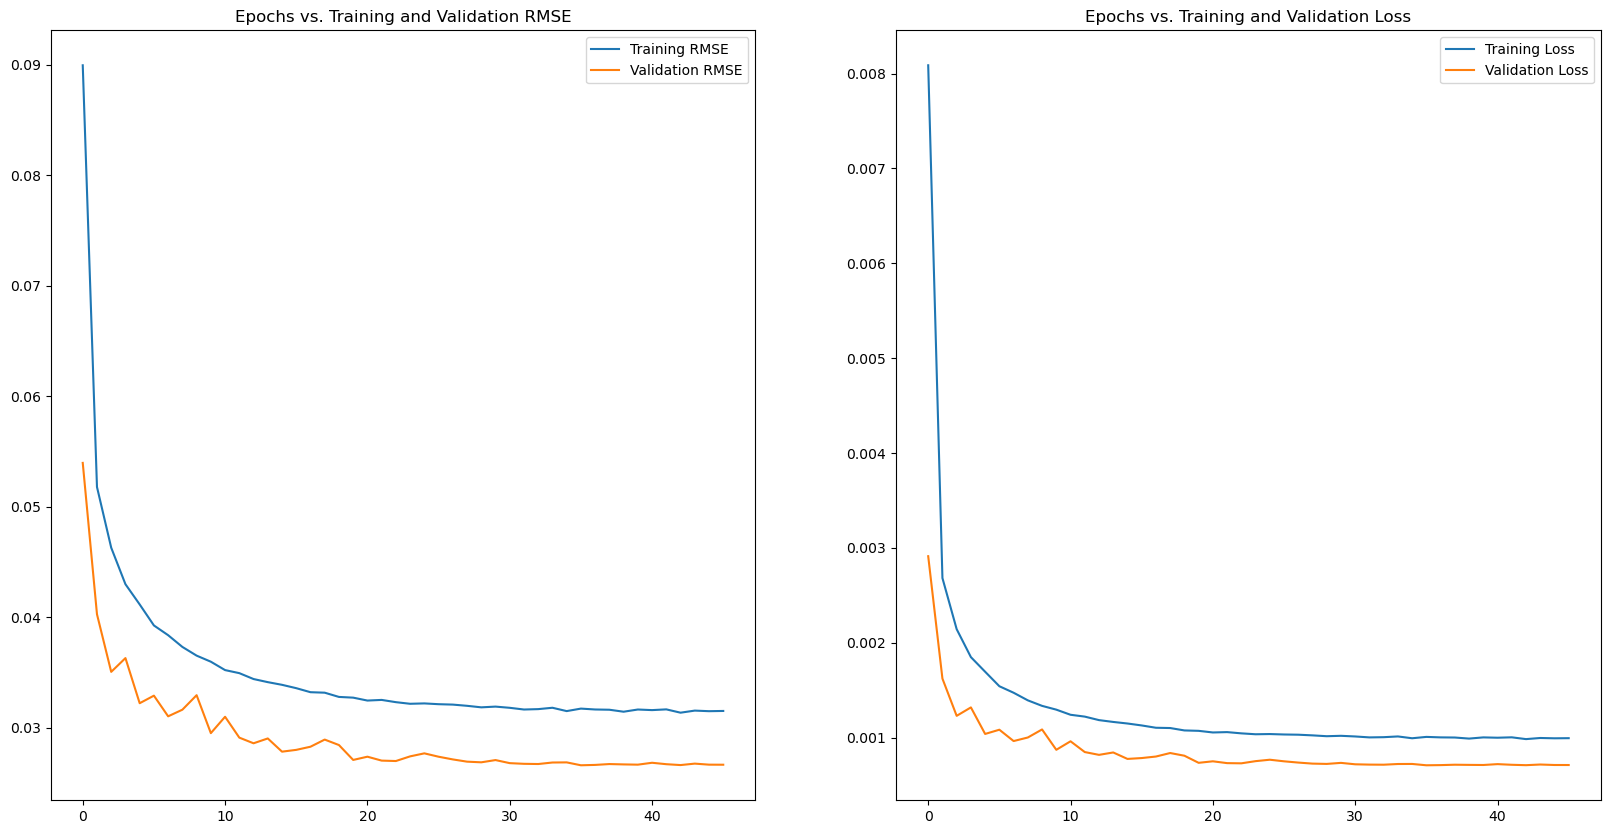

In [45]:
plot_model_rmse_and_loss(history)

In [7]:
print(X_train.shape)

(27024, 24, 17)


In [ ]:
# Funktion zum Erstellen des Modells mit Hyperparametern
def build_rnn_model(hp):
    model = tf.keras.Sequential()
    
    # RNN-Schicht mit variabler Anzahl an Neuronen
    model.add(SimpleRNN(
        units=hp.Int('rnn_units', min_value=16, max_value=128, step=16), 
        input_shape=(None, X_train.shape[2])
    ))

    # Dropout-Schicht mit variabler Rate
    model.add(tf.keras.layers.Dropout(
        rate=hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    ))
    
    # Dense-Schicht mit variabler Neuronenzahl
    model.add(Dense(
        units=hp.Int('dense_units', min_value=8, max_value=64, step=8),
        activation='relu'
    ))
    
    # Output-Schicht
    model.add(Dense(1))
    
    # Optimizer mit variabler Lernrate
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    )
    
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Keras Tuner
tuner = kt.Hyperband(
    build_rnn_model,  # Modellfunktion
    objective='val_loss',  # Ziel: Validation Loss minimieren
    max_epochs=15,  # Maximale Anzahl an Epochen pro Trial
    factor=3,  # Anzahl der Trials wird mit jedem Schritt um den Faktor erhöht
    hyperband_iterations=1,  # Die Anzahl der Hyperband-Iterationen
    distribution_strategy=tf.distribute.MirroredStrategy(),
    directory='keras_tuner_rnn',  # Speicherort
    project_name='rnn_hyperband'
)

# Hyperparameter-Tuning ausführen
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Bestes Modell abrufen
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Beste RNN-Einheiten: {best_hps.get('rnn_units')}")
print(f"Beste Dense-Einheiten: {best_hps.get('dense_units')}")
print(f"Beste Lernrate: {best_hps.get('learning_rate')}")

# Bestes Modell neu trainieren
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_best.h5", monitor= "val_loss", save_best_only=True)
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose = 1, callbacks = [early_stopping, model_checkpoint])



Trial 90 Complete [00h 01m 11s]
val_loss: 0.0006085030036047101

Best val_loss So Far: 0.0005379760405048728
Total elapsed time: 00h 38m 37s
Beste RNN-Einheiten: 48
Beste Dense-Einheiten: 56
Beste Lernrate: 0.001
Epoch 1/50
845/845 [==============================] - 5s 5ms/step - loss: 0.0072 - val_loss: 0.0018
Epoch 2/50
845/845 [==============================] - 4s 5ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 3/50
845/845 [==============================] - 4s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/50
845/845 [==============================] - 4s 4ms/step - loss: 8.6478e-04 - val_loss: 7.2585e-04
Epoch 5/50
845/845 [==============================] - 4s 4ms/step - loss: 7.7408e-04 - val_loss: 8.0090e-04
Epoch 6/50
845/845 [==============================] - 4s 5ms/step - loss: 7.1749e-04 - val_loss: 6.2094e-04
Epoch 7/50
845/845 [==============================] - 4s 4ms/step - loss: 6.7661e-04 - val_loss: 6.6182e-04
Epoch 8/50
845/845 [==============================] - 4

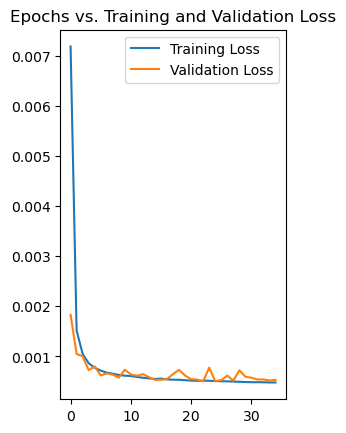

In [18]:
plot_model_rmse_and_loss(history)

In [19]:
rnn_model_best = load_model("rnn_best.h5")
predictions = rnn_model_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE: {rmse:.4f}')

125/125 [==============================] - 1s 2ms/step
RMSE: 0.0200


125/125 [==============================] - 0s 2ms/step


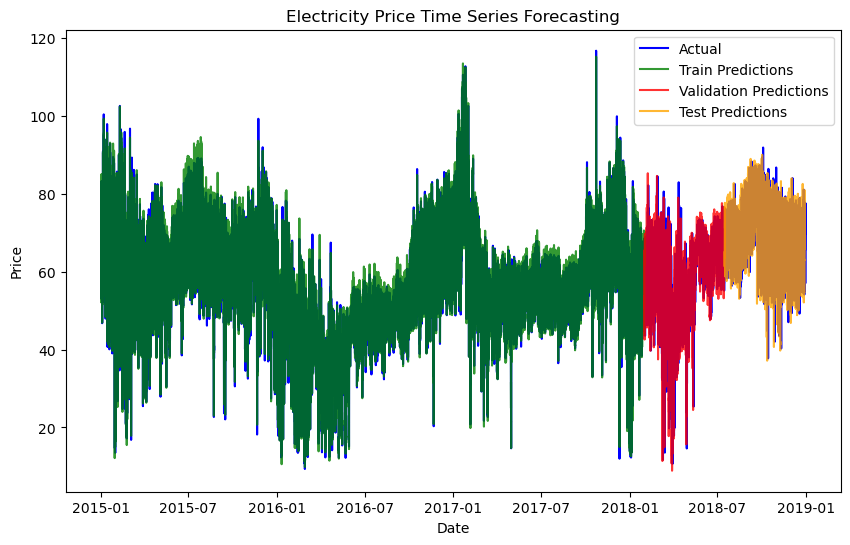

In [44]:
# Make predictions
train_predictions = rnn_model_best.predict(X_train)
validation_predictions = rnn_model_best.predict(X_val)
test_predictions = rnn_model_best.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler_y.inverse_transform(train_predictions)
validation_predictions = scaler_y.inverse_transform(validation_predictions)
test_predictions = scaler_y.inverse_transform(test_predictions)

# Plot predictions
plt.figure(figsize=(10, 6))

# Plot actual data
seq_length = 24
plt.plot(df_final_viz.index[seq_length:], df_final_viz['price actual'][seq_length:], label='Actual', color='blue')

# Plot training predictions
plt.plot(df_final_viz.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green', alpha = 0.8)

# Plot validation predictions
validation_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(validation_predictions))
plt.plot(df_final_viz.index[validation_pred_index], validation_predictions, label='Validation Predictions',color='red', alpha = 0.8)

# Plot testing predictions
test_pred_index = range(seq_length+len(train_predictions)+len(validation_predictions), seq_length+len(train_predictions)+len(validation_predictions)+len(test_predictions))
plt.plot(df_final_viz.index[test_pred_index], test_predictions, label='Test Predictions',color='orange', alpha = 0.8)

plt.title('Electricity Price Time Series Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
